# MMI Activity Recognition with Eye-Tracking Data

### Import of libraries
Version of libraries is logged in the log-file.

Tensorboard is loaded for graphical evaluation of single networks

In [19]:
# Load the TensorBoard notebook extension.
from sklearn.model_selection import train_test_split
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM,  Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
import json
import time
import datetime
from pathlib import Path
#from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings("ignore")


modules = {
    "TensorFlow" : tf.__version__,
    "Numpy" : np.__version__,
    "pandas" : pd.__version__
}

def return_duration(diff):
    hours, rem = divmod(diff, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)


print("Tensorflow at", tf.__version__)
print("All libraries successfully imported")

Tensorflow at 2.0.0
All libraries successfully imported


### Variables 

Most of these can be set by the user.

* **run_number** : Number of Run. Increment for new models.
* **path_to_data** : Path to datafiles.
* **file_name** : Name of final file. Needs a file extension.
* **file_extension** : File extension of files to join.
* **cameras** : Names of cameras to create models for.
* **ml_gpu_available** : Gets set by the program. Indicates if a GPU is available.
* **ml_train_split** : Ratio of Test/Train Data.
* **ml_optimizer** : Keras optimizer.
* **ml_loss** : Loss measure.
* **ml_accuracy** : Accuracy measure.
* **ml_steps_per_epoch** : Steps per epoch. Dependent on number of training lines
* **ml_batch_size** :  Number of samples in a batch.
* **ml_sequence_length** : Length of sequence. This translates to frames.
* **ml_epochs** : Epochs to train for.
* **ml_units** : Units of the first layer.
* **ml_validation_steps** : Steps for validation after each epoch.
* **ml_modelName** : Name of the file of the final model.
* **ml_manual_test** : Number of manual tests.
* **ml_evaluation_steps** : Steps for final evaluation.


In [21]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
gpu_available = tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
print("GPU available: ", gpu_available)

DEBUG = False

config = {
    "run_number" : 15,
    "path_to_data" : "final_data/",
    "file_name" : "concated_csv",
    "file_extension" : ".csv",
    "cameras" : ["cam_1", "cam_2", "cam_3"],
    "ml_gpu_available" : gpu_available,
    "ml_train_split" : 0.8,
    "ml_optimizer": "adam",
    "ml_loss" : "sparse_categorical_crossentropy",
    "ml_accuracy" : "sparse_categorical_accuracy", 
    "ml_batch_size":  1024,
    "ml_sequence_length": 15,
    "ml_epochs": 500,
    "ml_units": 366,
    "ml_modelName": "activity_recognizer",
    }

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5

GPU available:  True


### Create structures
Create folders:
* Folder for the model run
    * Folder for checkpoints **per camera**
    * Folder for the actual model as well as training evaluation **per camera**
        * Graphs for Accuracy and loss
        * CSV log of metrics during training
    * Folder for tensorboard logs **per camera**

In [22]:
# General output folder
output_folder = Path("models/")

# Folders for training
FOLDER_MODEL_OUTPUT = output_folder / ("RUN_" + str(config["run_number"]))
FOLDER_MODEL_CHECKPOINTS = FOLDER_MODEL_OUTPUT / "checkpoints"
FOLDER_MODEL_NN = FOLDER_MODEL_OUTPUT / "models"
FOLDER_MODEL_TENSORBOARD = FOLDER_MODEL_OUTPUT / "tensorboard_logs"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
if not os.path.exists(FOLDER_MODEL_OUTPUT):
    os.makedirs(FOLDER_MODEL_OUTPUT)
    os.makedirs(FOLDER_MODEL_CHECKPOINTS)
    os.makedirs(FOLDER_MODEL_NN)
    os.makedirs(FOLDER_MODEL_TENSORBOARD)

### Import Data
Read the file. 

If the file does not exist all CSV-files from the folder *"final_data"* are concatenated and saved as a single new file

In [23]:
# Read file 
df = pd.read_csv(config["path_to_data"] + config["file_name"] + config["file_extension"], delimiter=",", header=0)

# GREGOR
df = df.fillna(0)
mask = (df['class'] == "Konzentriert_arbeiten") & (df['gaze_direction_0_x'] == 0) & (df['gaze_direction_0_y'] == 0) &\
       (df['gaze_direction_0_z'] == 0) & (df['gaze_direction_1_x'] == 0) & (df['gaze_direction_1_y'] == 0) &\
       (df['gaze_direction_1_z'] == 0)
df['class'][mask] = "Keine_Person_erkannt"

print("All data: ", df.shape)

class_to_delete = df[df['class'] == "Suchen_Arbeitsfläche" ].index
df.drop(class_to_delete, inplace=True)

print("Removed 'Suchen_Arbeitsfläche': ", df.shape)

SIGNAL_COLUMN_NAMES = ['gaze_direction_0_x',
                   'gaze_direction_0_y', 'gaze_direction_0_z', 'gaze_direction_1_x', 'gaze_direction_1_y', 'gaze_direction_1_z',
                   'gaze_angle_x', 'gaze_angle_y', 'pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz',
                   'gaze_direction_left_x', 'gaze_direction_left_y', 'gaze_direction_left_z', 'gaze_start_left_x',
                   'gaze_start_left_y', 'gaze_start_left_z', 'gaze_start_right_x', 'gaze_start_right_y', 'gaze_start_right_z',
                   'gaze_direction_right_x', 'gaze_direction_right_y', 'gaze_direction_right_z', 'aoi_hit_lefteye_Oberer_Küchenschrank_1',
                   'aoi_hit_lefteye_Oberer_Küchenschrank_2', 'aoi_hit_lefteye_Oberer_Küchenschrank_3', 'aoi_hit_lefteye_Oberer_Küchenschrank_4',
                   'aoi_hit_lefteye_Oberer_Küchenschrank_5', 'aoi_hit_lefteye_Oberer_Küchenschrank_6', 'aoi_hit_lefteye_Oberer_Küchenschrank_7',
                   'aoi_hit_lefteye_Unterer_Küchenschrank_1', 'aoi_hit_lefteye_Unterer_Küchenschrank_2', 'aoi_hit_lefteye_Unterer_Küchenschrank_3_Oben',
                   'aoi_hit_lefteye_Unterer_Küchenschrank_3_Mitte', 'aoi_hit_lefteye_Unterer_Küchenschrank_3_Unten', 'aoi_hit_lefteye_Unterer_Küchenschrank_4',
                   'aoi_hit_lefteye_Unterer_Küchenschrank_5', 'aoi_hit_lefteye_Kühlschrank', 'aoi_hit_lefteye_Kühlschrank-Seitenansicht',
                   'aoi_hit_lefteye_Mikrowelle', 'aoi_hit_lefteye_Geschirrspüler', 'aoi_hit_lefteye_Herd_Schalthebel_1','aoi_hit_lefteye_Herd_Schalthebel_2',
                   'aoi_hit_lefteye_Herd_Zeitanzeige', 'aoi_hit_lefteye_Herd', 'aoi_hit_lefteye_Cerankochfeld_Oben_Links','aoi_hit_lefteye_Cerankochfeld_Oben_Rechts',
                   'aoi_hit_lefteye_Cerankochfeld_Unten_Links', 'aoi_hit_lefteye_Cerankochfeld_Unten_Rechts', 'aoi_hit_lefteye_Spüle', 'aoi_hit_lefteye_Bereich_hinter_Spüle',
                   'aoi_hit_lefteye_Bereich_vor_Spüle', 'aoi_hit_lefteye_Arbeitsfläche_1', 'aoi_hit_lefteye_Arbeitsfläche_2', 'aoi_hit_lefteye_Arbeitsfläche_3',
                   'aoi_hit_lefteye_Schrankunterseiten', 'aoi_hit_lefteye_Boden', 'aoi_hit_lefteye_Decke', 'aoi_hit_lefteye_Mauer_Links',
                   'aoi_hit_lefteye_Mauer_rechts', 'aoi_hit_lefteye_Hinten', 'aoi_hit_lefteye_Arbeitsfläche_1_Vorne', 'aoi_hit_lefteye_Arbeitsfläche_Spüle_Vorne',
                   'aoi_hit_lefteye_Arbeitsfläche_2_Vorne', 'aoi_hit_lefteye_Arbeitsfläche_Ofen_Vorne', 'aoi_hit_lefteye_Arbeitsfläche_3_Vorne',
                   'aoi_hit_lefteye_Rückwand_ABF_1', 'aoi_hit_lefteye_Rückwand_ABF_Spüle', 'aoi_hit_lefteye_Rückwand_ABF_2',
                   'aoi_hit_lefteye_Rückwand_ABF_Ofen', 'aoi_hit_lefteye_Rückwand_ABF_3', 'aoi_hit_righteye_Oberer_Küchenschrank_1',
                   'aoi_hit_righteye_Oberer_Küchenschrank_2', 'aoi_hit_righteye_Oberer_Küchenschrank_3', 'aoi_hit_righteye_Oberer_Küchenschrank_4',
                   'aoi_hit_righteye_Oberer_Küchenschrank_5', 'aoi_hit_righteye_Oberer_Küchenschrank_6', 'aoi_hit_righteye_Oberer_Küchenschrank_7',
                   'aoi_hit_righteye_Unterer_Küchenschrank_1', 'aoi_hit_righteye_Unterer_Küchenschrank_2', 'aoi_hit_righteye_Unterer_Küchenschrank_3_Oben',
                   'aoi_hit_righteye_Unterer_Küchenschrank_3_Mitte', 'aoi_hit_righteye_Unterer_Küchenschrank_3_Unten', 'aoi_hit_righteye_Unterer_Küchenschrank_4',
                   'aoi_hit_righteye_Unterer_Küchenschrank_5', 'aoi_hit_righteye_Kühlschrank', 'aoi_hit_righteye_Kühlschrank-Seitenansicht',
                   'aoi_hit_righteye_Mikrowelle', 'aoi_hit_righteye_Geschirrspüler', 'aoi_hit_righteye_Herd_Schalthebel_1', 'aoi_hit_righteye_Herd_Schalthebel_2',
                   'aoi_hit_righteye_Herd_Zeitanzeige', 'aoi_hit_righteye_Herd', 'aoi_hit_righteye_Cerankochfeld_Oben_Links', 'aoi_hit_righteye_Cerankochfeld_Oben_Rechts',
                   'aoi_hit_righteye_Cerankochfeld_Unten_Links', 'aoi_hit_righteye_Cerankochfeld_Unten_Rechts', 'aoi_hit_righteye_Spüle',
                   'aoi_hit_righteye_Bereich_hinter_Spüle', 'aoi_hit_righteye_Bereich_vor_Spüle', 'aoi_hit_righteye_Arbeitsfläche_1',
                   'aoi_hit_righteye_Arbeitsfläche_2', 'aoi_hit_righteye_Arbeitsfläche_3', 'aoi_hit_righteye_Schrankunterseiten', 'aoi_hit_righteye_Boden',
                   'aoi_hit_righteye_Decke', 'aoi_hit_righteye_Mauer_Links', 'aoi_hit_righteye_Mauer_rechts', 'aoi_hit_righteye_Hinten',
                   'aoi_hit_righteye_Arbeitsfläche_1_Vorne', 'aoi_hit_righteye_Arbeitsfläche_Spüle_Vorne','aoi_hit_righteye_Arbeitsfläche_2_Vorne',
                   'aoi_hit_righteye_Arbeitsfläche_Ofen_Vorne', 'aoi_hit_righteye_Arbeitsfläche_3_Vorne', 'aoi_hit_righteye_Rückwand_ABF_1',
                   'aoi_hit_righteye_Rückwand_ABF_Spüle', 'aoi_hit_righteye_Rückwand_ABF_2', 'aoi_hit_righteye_Rückwand_ABF_Ofen',
                   'aoi_hit_righteye_Rückwand_ABF_3']

TARGET_CLASS_NAMES = ["Keine_Klasse",
                        "Konzentriert_arbeiten",
                        "Suchen_Oberschrank",
                        "Suchen_Unterschrank",
                        "Wartend",
                        "Keine_Person_erkannt"]

All data:  (892608, 125)
Removed 'Suchen_Arbeitsfläche':  (892572, 125)


### Data preparation
Every camera has its own predition model.

Therefore the data is split on camera ID.

* labels get integer encoded 
* a new dataset is created for each camera

In [24]:
# Label Encoder
le = LabelEncoder()
le.fit(TARGET_CLASS_NAMES)


LabelEncoder()

In [25]:
data = {}
for cam in config["cameras"]:
    data[cam] = {}
   
    # filter data
    df_ = df.loc[df['client_id'] == cam]
    
    # split into x and y
    __data_signals__ =  df_[SIGNAL_COLUMN_NAMES].values
    __data_targets__ = le.transform(df_['class'].values)
    
    # Might have to reshape y_Data 
    __data_targets__ = __data_targets__.reshape(-1,1)
    
    #Class wheights
    data[cam]["labels_distribution"] = df_["class"].value_counts() 
    
    # info
    data[cam]["num_data"] = __data_signals__.shape[0]
    data[cam]["cam_id"] = cam
    config["cam"] = cam
    
    # shapes of samples
    data[cam]["num_x_signals"] = __data_signals__.shape[1]
    data[cam]["num_y_signals"] = __data_targets__.shape[1]
    
    # set data 
    data[cam]["x_data"] = __data_signals__
    data[cam]["y_data"] = __data_targets__
    data[cam]["num_data_total"] = __data_targets__.shape[0]
    
    num_train_data_total = int(__data_signals__.shape[0] * config["ml_train_split"])
    
    
    print(f"Prepared data for {cam} with {__data_signals__.shape[0]} samples " +
          f"\n Signals: {__data_signals__.shape[0]} samples with {__data_signals__.shape[1]} features" +
          f"\n Targets: {__data_targets__.shape[0]} samples with {__data_targets__.shape[1]} dimensions")
    print()     

Prepared data for cam_1 with 257209 samples 
 Signals: 257209 samples with 122 features
 Targets: 257209 samples with 1 dimensions

Prepared data for cam_2 with 225124 samples 
 Signals: 225124 samples with 122 features
 Targets: 225124 samples with 1 dimensions

Prepared data for cam_3 with 410239 samples 
 Signals: 410239 samples with 122 features
 Targets: 410239 samples with 1 dimensions



### Plot some of our data

Distribution over all cameras


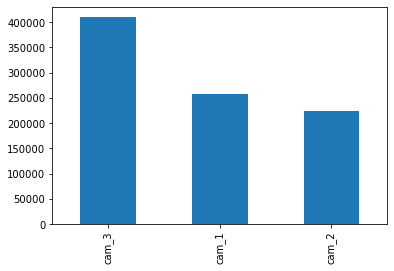

In [26]:
labels_dist = df["client_id"].value_counts()
print(f"Distribution over all cameras")
labels_dist.plot(kind="bar")

Keine_Person_erkannt     621991
Konzentriert_arbeiten     80747
Suchen_Oberschrank        54231
Suchen_Unterschrank       50838
Wartend                   49312
Keine_Klasse              35453
Name: class, dtype: int64
Distribution of classes over all cameras


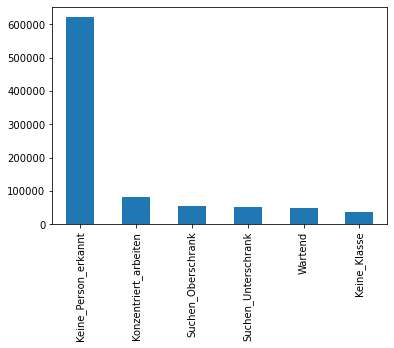

In [27]:
labels_dist = df["class"].value_counts()
print(labels_dist)
print(f"Distribution of classes over all cameras")
labels_dist.plot(kind="bar")

### Methods for training

* method for creating the batch generator
* method for training the model
* method for saving graphics 

In [28]:
#Generator for batches
def batch_generator(batch_size, sequence_length, x_data, y_data, num_train_data, num_x_signals, num_y_signals):
    # Keep on producing batches
    while True:
        # make Placeholders for the data
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)

        y_shape = (batch_size, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)

        # Generate a single batch
        batches_added = 0
        while batches_added < batch_size:
            idx = np.random.randint(num_train_data - sequence_length)
            same_class = True
            
            for incrementor in range(0, sequence_length):
                if not np.array_equal(y_data[idx + incrementor], y_data[idx]):
                    same_class = False
                    break

            if same_class:
                x_batch[batches_added] = x_data[idx:idx + sequence_length]
                y_batch[batches_added] = y_data[idx + sequence_length - 1]
                batches_added = batches_added + 1
                #print("Train Batch added")

        yield x_batch, y_batch
 
#This is the actual training method 
# noinspection PyBroadException
def train_model(cur_dataset):
    # create data
    data_generator = batch_generator(batch_size= config["ml_batch_size"] ,
                             sequence_length=config["ml_sequence_length"],
                             x_data=cur_dataset["x_data"],
                             y_data=cur_dataset["y_data"],
                             num_train_data=cur_dataset["num_data_total"],
                             num_x_signals=cur_dataset["num_x_signals"],
                             num_y_signals=cur_dataset["num_y_signals"])
    
    def generator_to_array(generator, steps_per_epoch, batch_size, sequence_length, num_x_signals, num_y_signales):
        x_ = np.zeros((steps_per_epoch, batch_size, sequence_length, num_x_signals))
        y_ = np.zeros((steps_per_epoch, batch_size, num_y_signales))
        for idx in range(steps_per_epoch):
            x_sample , y_sample = next(generator)
            x_[idx] = x_sample
            y_[idx] = y_sample
        
        x_ = x_.reshape(steps_per_epoch*batch_size, sequence_length, num_x_signals)
        y_ = y_.reshape(steps_per_epoch*batch_size, num_y_signales)
        
        return x_ , y_
    
    num_samples = int(cur_dataset["num_data_total"] / config["ml_batch_size"]) 
    
    x_data, y_data = generator_to_array(data_generator,
                                        num_samples,
                                        config["ml_batch_size"],
                                        config["ml_sequence_length"],
                                        cur_dataset["num_x_signals"],
                                        cur_dataset["num_y_signals"])
    
    print("Generated ", x_data.shape[0], " samples")
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=1 - config["ml_train_split"])  
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1 - config["ml_train_split"])

    # compute class weights
    print("Shapes:")
    print("\t x-train:", x_train.shape)
    print("\t y-train:", y_train.shape)
    print("\t x-val:", x_val.shape)
    print("\t y-val:", y_val.shape)
    print("\t x-test:", x_test.shape)
    print("\t y-test:", y_test.shape)
    print()

    
    # Folders
    model_folder = FOLDER_MODEL_NN / str(cur_dataset["cam_id"])
    log_folder = FOLDER_MODEL_NN / str(cur_dataset["cam_id"]) / "logs"
    checkpoint_folder = FOLDER_MODEL_CHECKPOINTS / str(cur_dataset["cam_id"])
    tensorboard_folder = FOLDER_MODEL_TENSORBOARD / str(cur_dataset["cam_id"])   
    
    # create Folders
    model_folder.mkdir(parents=True, exist_ok=True)               
    log_folder.mkdir(parents=True, exist_ok=True)        
    checkpoint_folder.mkdir(parents=True, exist_ok=True) 
    tensorboard_folder.mkdir(parents=True, exist_ok=True)
    
    # Callbacks
    callback_checkpoint = ModelCheckpoint(filepath=str(checkpoint_folder) + "\\",
                                          monitor="val_loss",
                                          verbose=1,
                                          save_weights_only=True,
                                          save_best_only=True)
    
    #callback_early_stopping_loss = EarlyStopping(monitor="val_loss",
    #                                             patience=50,
    #                                             verbose=1,
    #                                             restore_best_weights=True)
    
    callback_early_stopping_acc = EarlyStopping(monitor="val_categorical_accuarcy",
                                                patience=25,
                                                verbose=1,
                                                restore_best_weights=True)
    
    callback_CSVLogger = CSVLogger(filename=str(log_folder) + "\csv_log.csv",
                                            separator=";",
                                            append=False)
    
    callback_tensorboard = TensorBoard(log_dir=str(tensorboard_folder) + "\\",
                                       histogram_freq=1,
                                       write_graph=True,
                                       write_images=True,
                                       update_freq="batch")
    
    callbacks = [callback_checkpoint,
                 callback_early_stopping_acc,
                 callback_tensorboard,
                 callback_CSVLogger]
    
    # Metrics
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="categorical_accuarcy")]     
        
    # define model architecture
    model = Sequential()
    #model.add(Dense(244, input_shape=(config["ml_sequence_length"], cur_dataset["num_x_signals"])))
    model.add(LSTM(units=config["ml_units"],
                return_sequences=True,
                input_shape=(config["ml_sequence_length"], cur_dataset["num_x_signals"]),
                recurrent_dropout=0.3))
    model.add(LSTM(units=config["ml_units"],
                return_sequences=False,
                recurrent_dropout=0.3,
                input_shape=(config["ml_sequence_length"], cur_dataset["num_x_signals"])))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=122))
    model.add(Activation("relu"))
    model.add(Dense(units=len(TARGET_CLASS_NAMES)))
    model.add(Activation("softmax"))
    
    # Compile 
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=config["ml_optimizer"],
                  metrics=metrics)
    model.summary()
      
    # shorten training for debug 
    if DEBUG:
        __steps_per_epoch_train__ = 10
        __steps_per_epoch_validation__ = 10
    
    cur_dataset["class_weights"] = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train.flatten())
    
    # start training
    start_timer = time.time()
    history = model.fit(x=x_train,
                        y=y_train,
                        class_weight=cur_dataset["class_weights"],
                        batch_size =config["ml_batch_size"],
                        epochs=config["ml_epochs"],
                        callbacks=callbacks,
                        validation_data=(x_val, y_val),
                        verbose=1)

    stop_timer = time.time()     
    duration = return_duration(stop_timer - start_timer)
    
    # Save the model to file
    # TODO we need this https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb
    model.save(model_folder / (config["ml_modelName"] + "_RUN_" + str(config["run_number"]) + "_" + cur_dataset["cam_id"] + "_NN.h5"))
    
    # Save graphics of acc and loss   
    save_graphics(history ,config["run_number"], cur_dataset, log_folder)
    
    # Evaluation
    # todo Daten in arrays Accuracy, RPecision, Recall TP, TN, Fp, & FN
    result = model.evaluate(x=x_test,
                            y= y_test,
                            batch_size=config["ml_batch_size"])
    
    # Print all metrics
    metrics = {}
    try:
        for res, metric in zip(result, model.metrics_names):
            metrics[metric] = str(res)    
    except:
        pass
    
    # Evaluate more metrics
    # https://stackoverflow.com/questions/47899463/how-to-extract-false-positive-false-negative-from-a-confusion-matrix-of-multicl 
    y_test_pred = model.predict(x_test)
    save_eval_graphics(y_test, y_test_pred ,config["run_number"], cur_dataset["cam_id"], log_folder)
    print()
    print("Saving log")
    
    # Save config and textual results 
    log = {"parameters" : config,
           "date": datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S"),
           "num_data": cur_dataset["num_data"],
           "modules" : modules,
           "metrics" : metrics,
           "class_weights" : str(cur_dataset["class_weights"]),
           "signal_labels" : SIGNAL_COLUMN_NAMES,  
           "targets_labels" : le.classes_.tolist(), 
           "label_distribution" : str(cur_dataset["labels_distribution"]),
           "model_definition" : model.to_json(),
           "duration" : duration}   

    with open(log_folder / ("RUN_" + str(config["run_number"]) + "_" + cur_dataset["cam_id"] + "_log.json"), mode="w" ,encoding='utf-8') as f:
        json.dump(log, f, ensure_ascii=False, indent=4) 
        f.close()
                
    print(f"Saved log file for {cur_dataset['cam_id']}")  
   
#After a successful training graphs can be plotted showing the metrics
def save_graphics(history, run_number ,cur_dataset, path):  
    
    #distribution graph
    cur_dataset["labels_distribution"].plot(kind='barh')
    plt.ylabel('Anzahl an Datensätzen')
    plt.title(f'Verteilung der Daten für {cur_dataset["cam_id"].replace("_", " ")}')
    plt.tight_layout()
    plt.savefig(path / ("RUN_" + str(config["run_number"]) + "_" + cur_dataset["cam_id"] + "_" +"_distribution.png"))
    plt.clf()
    plt.cla()
    plt.close()
    
    #metrics
    for metric in history.history:
        if not "val_" in metric:
            name = metric.replace("_", " ").capitalize()
            plt.plot(history.history[metric], label="Train")                                
            plt.plot(history.history["val_" + metric], linestyle="--", label="Validation")                            
            plt.title(f'Metrik: {name}')                                          
            plt.ylabel(name)                                                           
            plt.xlabel('Epoche')                                                              
            plt.legend()   
            plt.tight_layout()
            plt.savefig(path / ("RUN_" + str(run_number) + "_" + cur_dataset["cam_id"] + "_" + name +".png")) 
            plt.clf()
            plt.cla()
            plt.close()
            print(f"Saved graph for metric '{name}'")
  
def save_eval_graphics(y_true, y_pred, run_number, cam_id, path):
    # confusion matrix
    y_true = y_true.astype(int)
    #print(y_true)
    y_pred_refactored = []
    for row in y_pred:
        y_pred_refactored.append([tf.keras.backend.eval(tf.math.argmax(row))])
    #print(y_pred_refactored)            
    classes = {0: "Keine_Klasse",
               1: "Konzentriert_arbeiten",
               2: "Suchen_Oberschrank",
               3: "Suchen_Unterschrank",
               4: "Wartend",
               5: "Keine_Person_erkannt"}    
    
    labels_x_y = []
    for class_element in np.unique(y_true):
        labels_x_y.append(classes[class_element])
    cm = confusion_matrix(y_true, y_pred_refactored)
    plt.figure(figsize=(16,12))
    sns.heatmap(cm,annot=True, fmt="d", xticklabels=labels_x_y, yticklabels=labels_x_y, cmap="YlGnBu")
    #sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel('Richtiges Label')
    plt.xlabel('Vorausgesagtes label')
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.yticks(rotation=0)
    plt.savefig(path / ("RUN_" + str(run_number) + "_" + cam_id + "_cm.png"))   
    print("Saved graphic for metric 'Confusion matrix'")

### Training
Here we run the training algorithm. This is done for every camera once as we train different models for each view.

Currently training cam_1 out of 3
Starting at: 13:43:56
Generated  257024  samples
Shapes:
	 x-train: (164495, 10, 122)
	 y-train: (164495, 1)
	 x-val: (41124, 10, 122)
	 y-val: (41124, 1)
	 x-test: (51405, 10, 122)
	 y-test: (51405, 1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 366)           715896    
_________________________________________________________________
lstm_7 (LSTM)                (None, 366)               1073112   
_________________________________________________________________
dropout_3 (Dropout)          (None, 366)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 122)               44774     
_________________________________________________________________
activation_6 (Activation)    (None, 122)               0         
______________

<Figure size 432x288 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

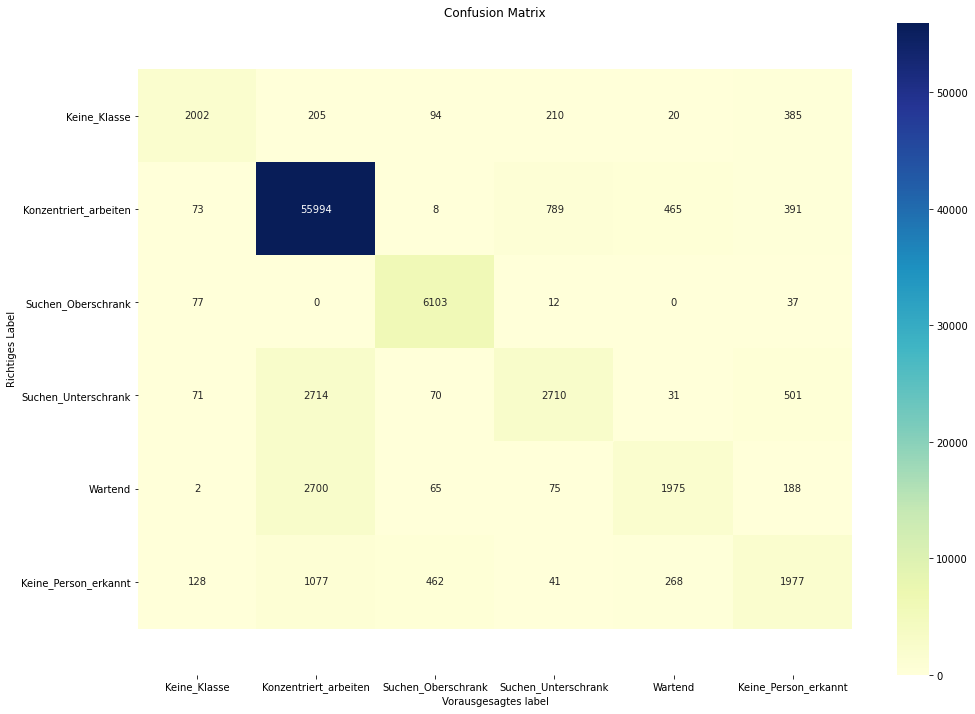

In [29]:
for i, dataset in enumerate(data):
    print(f"Currently training {data[dataset]['cam_id']} out of {len(data)}")
    print(f"Starting at: {time.strftime('%H:%M:%S', time.localtime())}")
    
    time_start = time.time()
    train_model(data[dataset])
    time_end = time.time()
    
    print("")
    print(f"Ending at: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f"Duration: {return_duration(time_end-time_start)}")
    print("")
    print(f"Expected finish time for all runs: {time.strftime('%H:%M:%S', time.localtime(time.mktime(time.localtime()) + ((time_end-time_start)*(len(dataset)-(i+1)))))}")
    
    time.sleep(2)
    print("")
    print("")
    print("")
    print("")
    print("")

In [30]:
print("Training succesfull")

Training succesfull


TODO
After a successful training, tensorboard graphs can be plotted showing the metrics    

In [31]:
#%reload_ext tensorboard
%tensorboard --logdir models/RUN_5/tensorboard_logs


Launching TensorBoard...